In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
X_train = pd.read_csv("MNIST_train_small.csv", header = None)
y_train = X_train.iloc[:,0]
X_train = X_train.drop(X_train.columns[0], axis=1)

X_test = pd.read_csv("MNIST_test_small.csv", header = None)
y_test = X_test.iloc[:,0]
X_test = X_test.drop(X_test.columns[0], axis=1)

In [3]:
def euclidean_distance (vec1 , vec2):
    difvec = np.subtract(vec1, vec2) 
    sqvec = np.square(difvec)
    dist = np.sum(sqvec)
    return dist

In [4]:
def predict_for_multiple_k(x, dist_function , X, y, k_values , LOOCV = False , p = None):
    dist_to_all = []

    for row, index in zip(X, y.index.values):
        if p is not None:
            dist = dist_function(x, row, p)
        else:
            dist = dist_function(x, row)
        dist_to_all.append((float(dist), int(index)))

    dist_to_all = sorted(dist_to_all, key=lambda tup: tup[0])
    
    if LOOCV:
        dist_to_all = dist_to_all[1:] + [ dist_to_all[0]]
        
    predictions = []
    for k in k_values:
        k_original = k
        neighbor_indeces = [x[1] for x in dist_to_all[:k]] 
        neighbor_classifications = y.take(neighbor_indeces) 
        closest = neighbor_classifications.mode()
        
        # In case there is a tie for a prediction , add more elements
        while len( closest ) > 1:
            k=k+1
            neighbor_indeces = [x[1] for x in dist_to_all[:k]]
            neighbor_classifications = y.take(neighbor_indeces) 
            closest = neighbor_classifications.mode()
            
        prediction = closest.iloc[0]
        predictions.append(( k_original , prediction ))
    return predictions


In [5]:
def get_accuracies(X_test, y_test, X_train, y_train, distance_function = euclidean_distance, k = [10], updates = 250):
  X_train_num = X_train.to_numpy()
  iter = 0
  correct_counters = dict([(x, {"correct": 0, "false": 0}) for x in k])
  for index, row in X_test.iterrows():
    preds = predict_for_multiple_k(row.to_numpy(), distance_function, X_train_num, y_train, k)
    correct = y_test.iloc[index]
    for k_val, pred in preds:
      if correct == pred:
        correct_counters[k_val]["correct"] += + 1
      else:
        correct_counters[k_val]["false"] += + 1
    iter = iter + 1
    if iter % updates == 0:
      print(f'iter: {index} {correct_counters}')
  return correct_counters

In [6]:
accuracies_test = get_accuracies(X_test, y_test, X_train, y_train, euclidean_distance, list(range(1,21)), 1000)
accuracies_train = get_accuracies(X_train, y_train, X_train, y_train, euclidean_distance, list(range(1,21)), 1000)

iter: 999 {1: {'correct': 915, 'false': 85}, 2: {'correct': 924, 'false': 76}, 3: {'correct': 924, 'false': 76}, 4: {'correct': 925, 'false': 75}, 5: {'correct': 921, 'false': 79}, 6: {'correct': 919, 'false': 81}, 7: {'correct': 916, 'false': 84}, 8: {'correct': 912, 'false': 88}, 9: {'correct': 908, 'false': 92}, 10: {'correct': 902, 'false': 98}, 11: {'correct': 902, 'false': 98}, 12: {'correct': 899, 'false': 101}, 13: {'correct': 898, 'false': 102}, 14: {'correct': 897, 'false': 103}, 15: {'correct': 898, 'false': 102}, 16: {'correct': 895, 'false': 105}, 17: {'correct': 893, 'false': 107}, 18: {'correct': 891, 'false': 109}, 19: {'correct': 885, 'false': 115}, 20: {'correct': 885, 'false': 115}}
iter: 999 {1: {'correct': 1000, 'false': 0}, 2: {'correct': 964, 'false': 36}, 3: {'correct': 964, 'false': 36}, 4: {'correct': 949, 'false': 51}, 5: {'correct': 942, 'false': 58}, 6: {'correct': 941, 'false': 59}, 7: {'correct': 938, 'false': 62}, 8: {'correct': 928, 'false': 72}, 9: {'c

In [7]:
def calc_emp_risk(accuracies):
    # Get empirical risk for each k
    empirical_risks = {}
    for k, loss in accuracies.items():
        # Get size of first item (should all be equal)
        n = sum(loss.values())

        # Calc risk
        risk = (1/n)*loss['false']
        empirical_risks[k] = risk
        
    # Get best empirical risk for k
    min_val = min(empirical_risks.values())
    optimal_k = [k for k in empirical_risks if empirical_risks[k] == min_val][0] # argmin for dict
    
    return empirical_risks, optimal_k

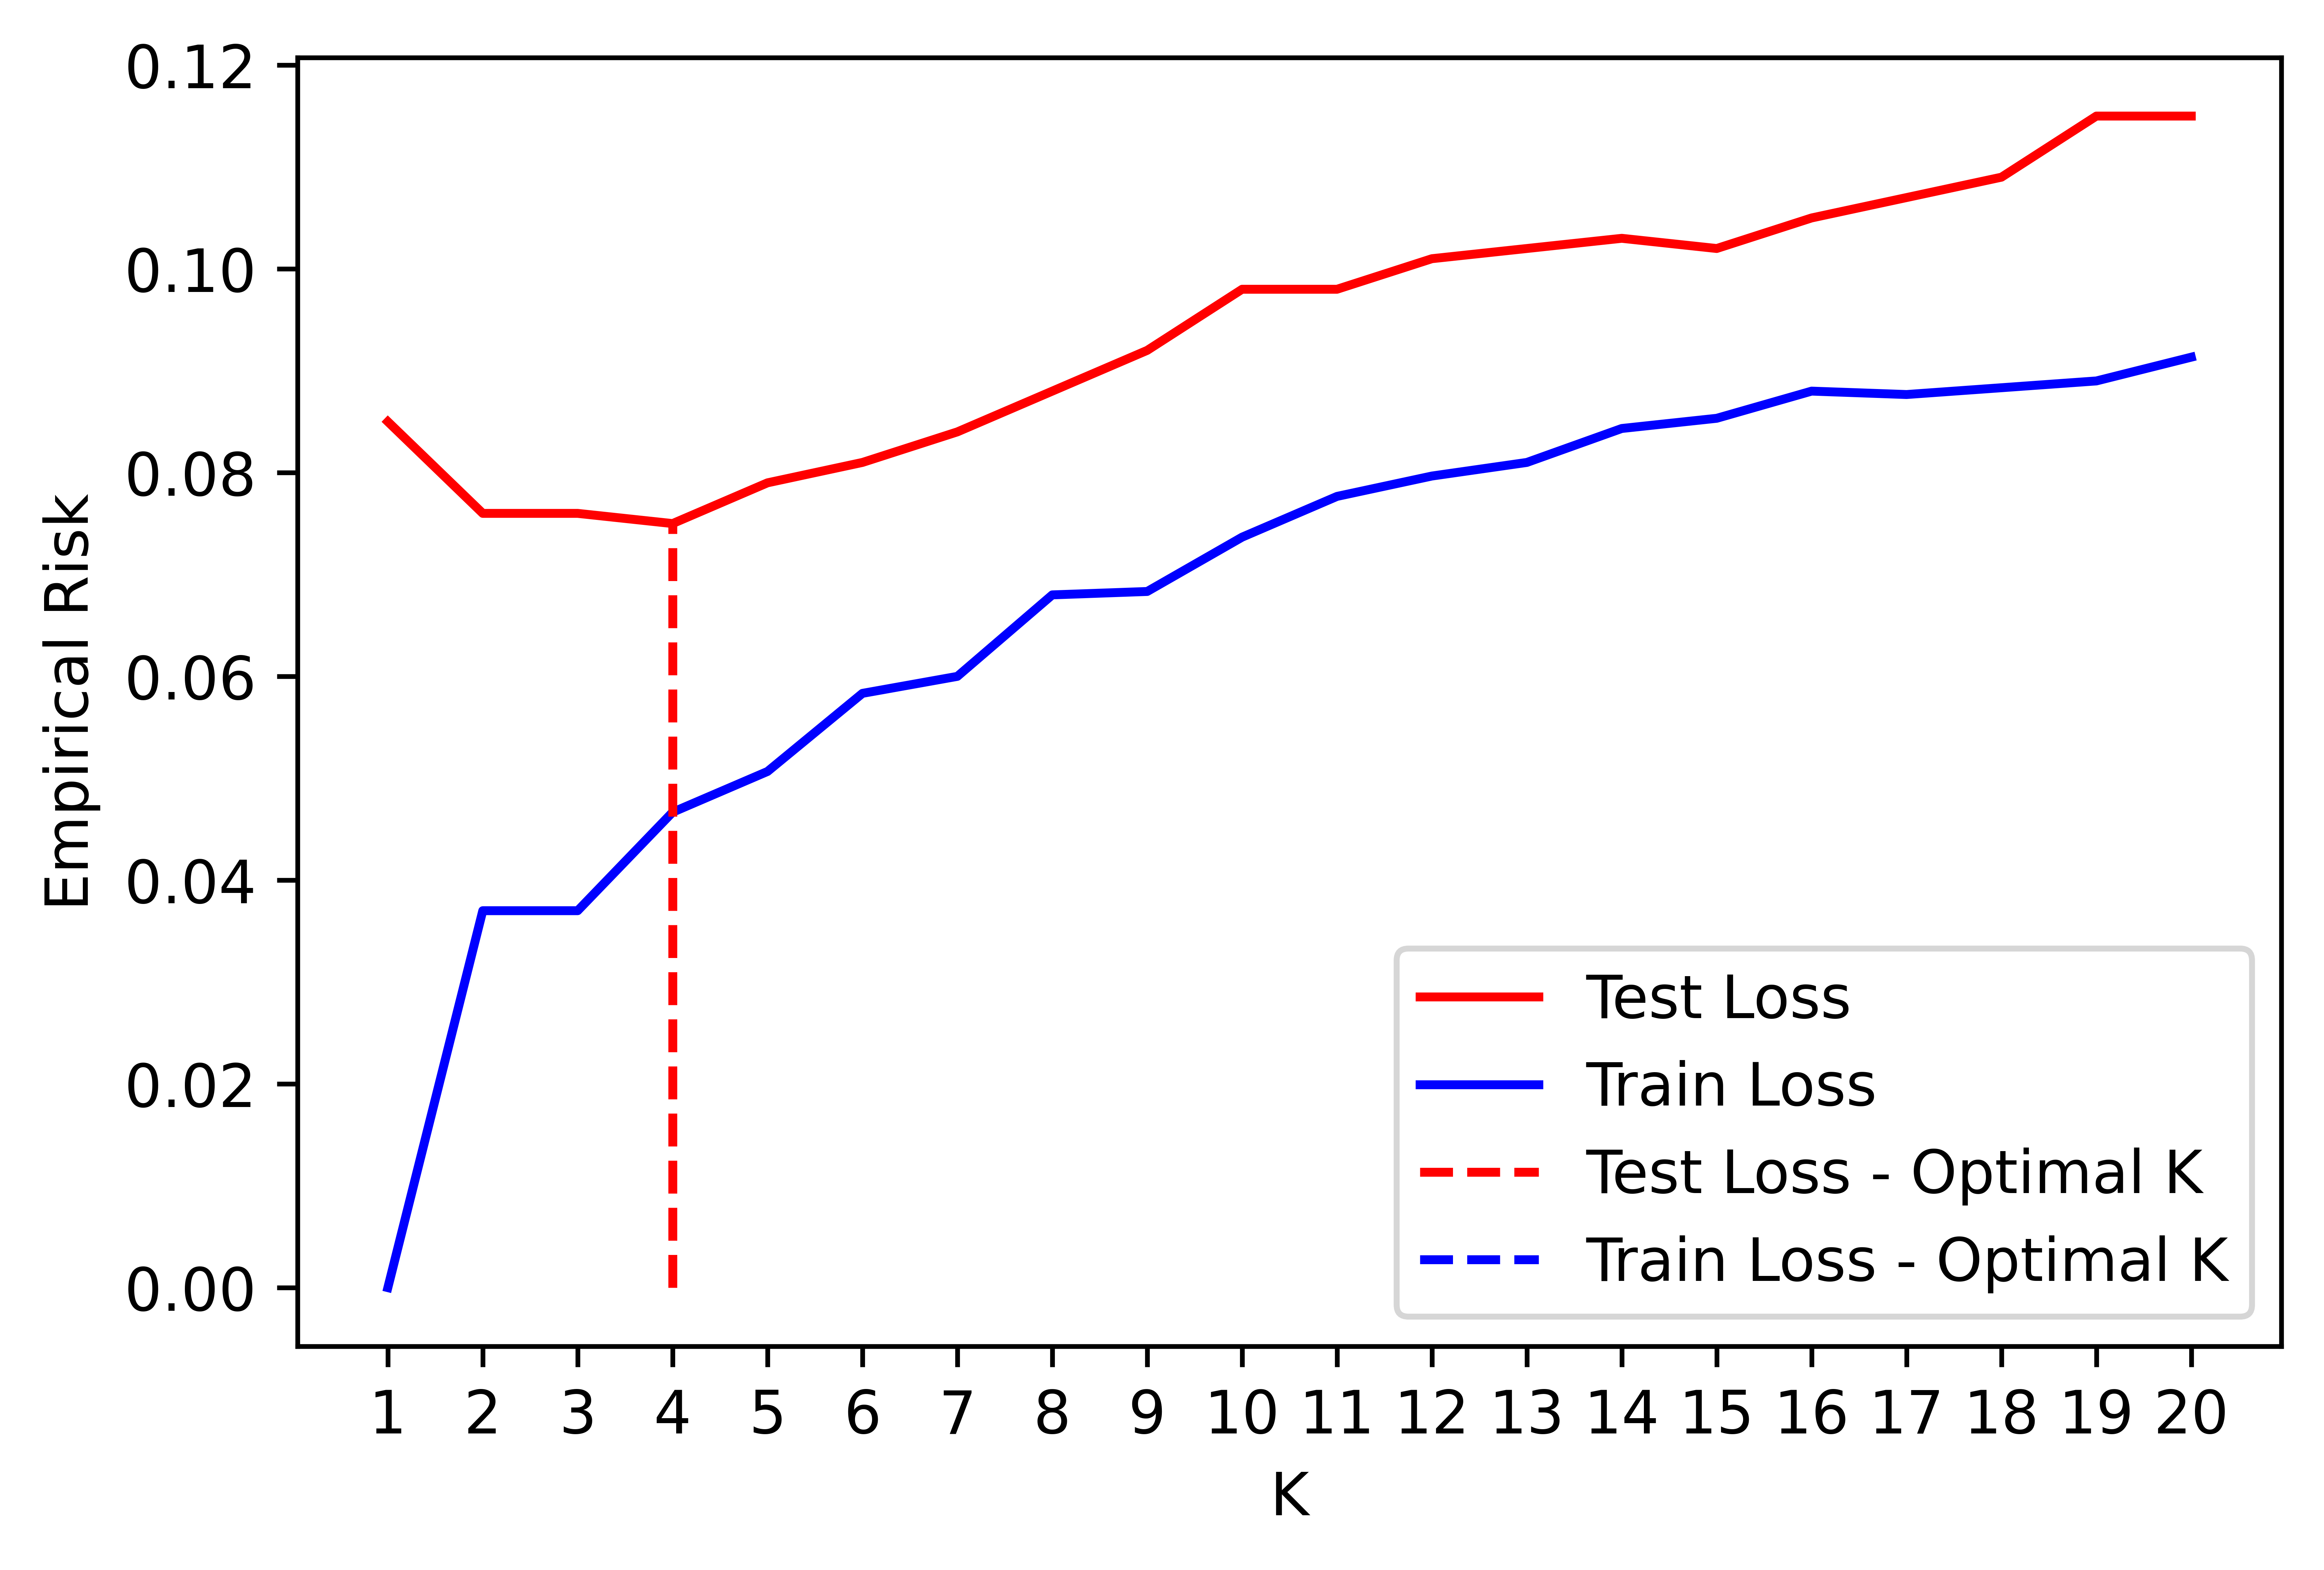

In [8]:
import matplotlib.pyplot as plt


x_val_test = [x for x in accuracies_test]
test_risks, test_argmin_k = calc_emp_risk(accuracies_test)
y_val_test = list(test_risks.values())

x_val_train = [x for x in accuracies_train]
train_risks, train_argmin_k = calc_emp_risk(accuracies_train)
y_val_train = list(train_risks.values())

plt.figure(dpi=1200)
plt.plot(x_val_test, y_val_test, label = 'Test Loss', color='r')
plt.plot(x_val_train, y_val_train, label = "Train Loss", color='b')
plt.vlines(test_argmin_k, 0, test_risks[test_argmin_k], label='Test Loss - Optimal K', linestyles='--', colors='r')
plt.vlines(train_argmin_k, 0, train_risks[train_argmin_k], label='Train Loss - Optimal K', linestyles='--', colors='b')
#plt.title('Empirical Risk for different K')
plt.legend()
plt.ylabel("Empirical Risk")
plt.xlabel("K")
plt.xticks(x_val_test)
plt.savefig("K_comparison.jpeg")
plt.show()

Question B:

In [9]:
def get_accuracies_LOOCV(X_train, y_train, distance_function = euclidean_distance, k = [10], updates = 250):
  X_train_num = X_train.to_numpy()
  iter = 0
  correct_counters = dict([(x, {"correct": 0, "false": 0}) for x in k])
  for index, row in X_train.iterrows():
    preds = predict_for_multiple_k(row.to_numpy(), distance_function, X_train_num, y_train, k, LOOCV = True)
    correct = y_train.iloc[index]
    for k_val, pred in preds:
      if correct == pred:
        correct_counters[k_val]["correct"] += + 1
      else:
        correct_counters[k_val]["false"] += + 1
    iter = iter + 1
    if iter % updates == 0:
      print(f'iter: {index} {correct_counters}')
  return correct_counters

In [10]:
accuracies_LOOCV = get_accuracies_LOOCV(X_train, y_train, euclidean_distance, list(range(1,21)), 1000)

iter: 999 {1: {'correct': 920, 'false': 80}, 2: {'correct': 917, 'false': 83}, 3: {'correct': 917, 'false': 83}, 4: {'correct': 919, 'false': 81}, 5: {'correct': 920, 'false': 80}, 6: {'correct': 912, 'false': 88}, 7: {'correct': 912, 'false': 88}, 8: {'correct': 912, 'false': 88}, 9: {'correct': 911, 'false': 89}, 10: {'correct': 909, 'false': 91}, 11: {'correct': 908, 'false': 92}, 12: {'correct': 905, 'false': 95}, 13: {'correct': 904, 'false': 96}, 14: {'correct': 908, 'false': 92}, 15: {'correct': 907, 'false': 93}, 16: {'correct': 904, 'false': 96}, 17: {'correct': 900, 'false': 100}, 18: {'correct': 897, 'false': 103}, 19: {'correct': 897, 'false': 103}, 20: {'correct': 896, 'false': 104}}
iter: 1999 {1: {'correct': 1846, 'false': 154}, 2: {'correct': 1846, 'false': 154}, 3: {'correct': 1846, 'false': 154}, 4: {'correct': 1837, 'false': 163}, 5: {'correct': 1841, 'false': 159}, 6: {'correct': 1835, 'false': 165}, 7: {'correct': 1835, 'false': 165}, 8: {'correct': 1823, 'false': 

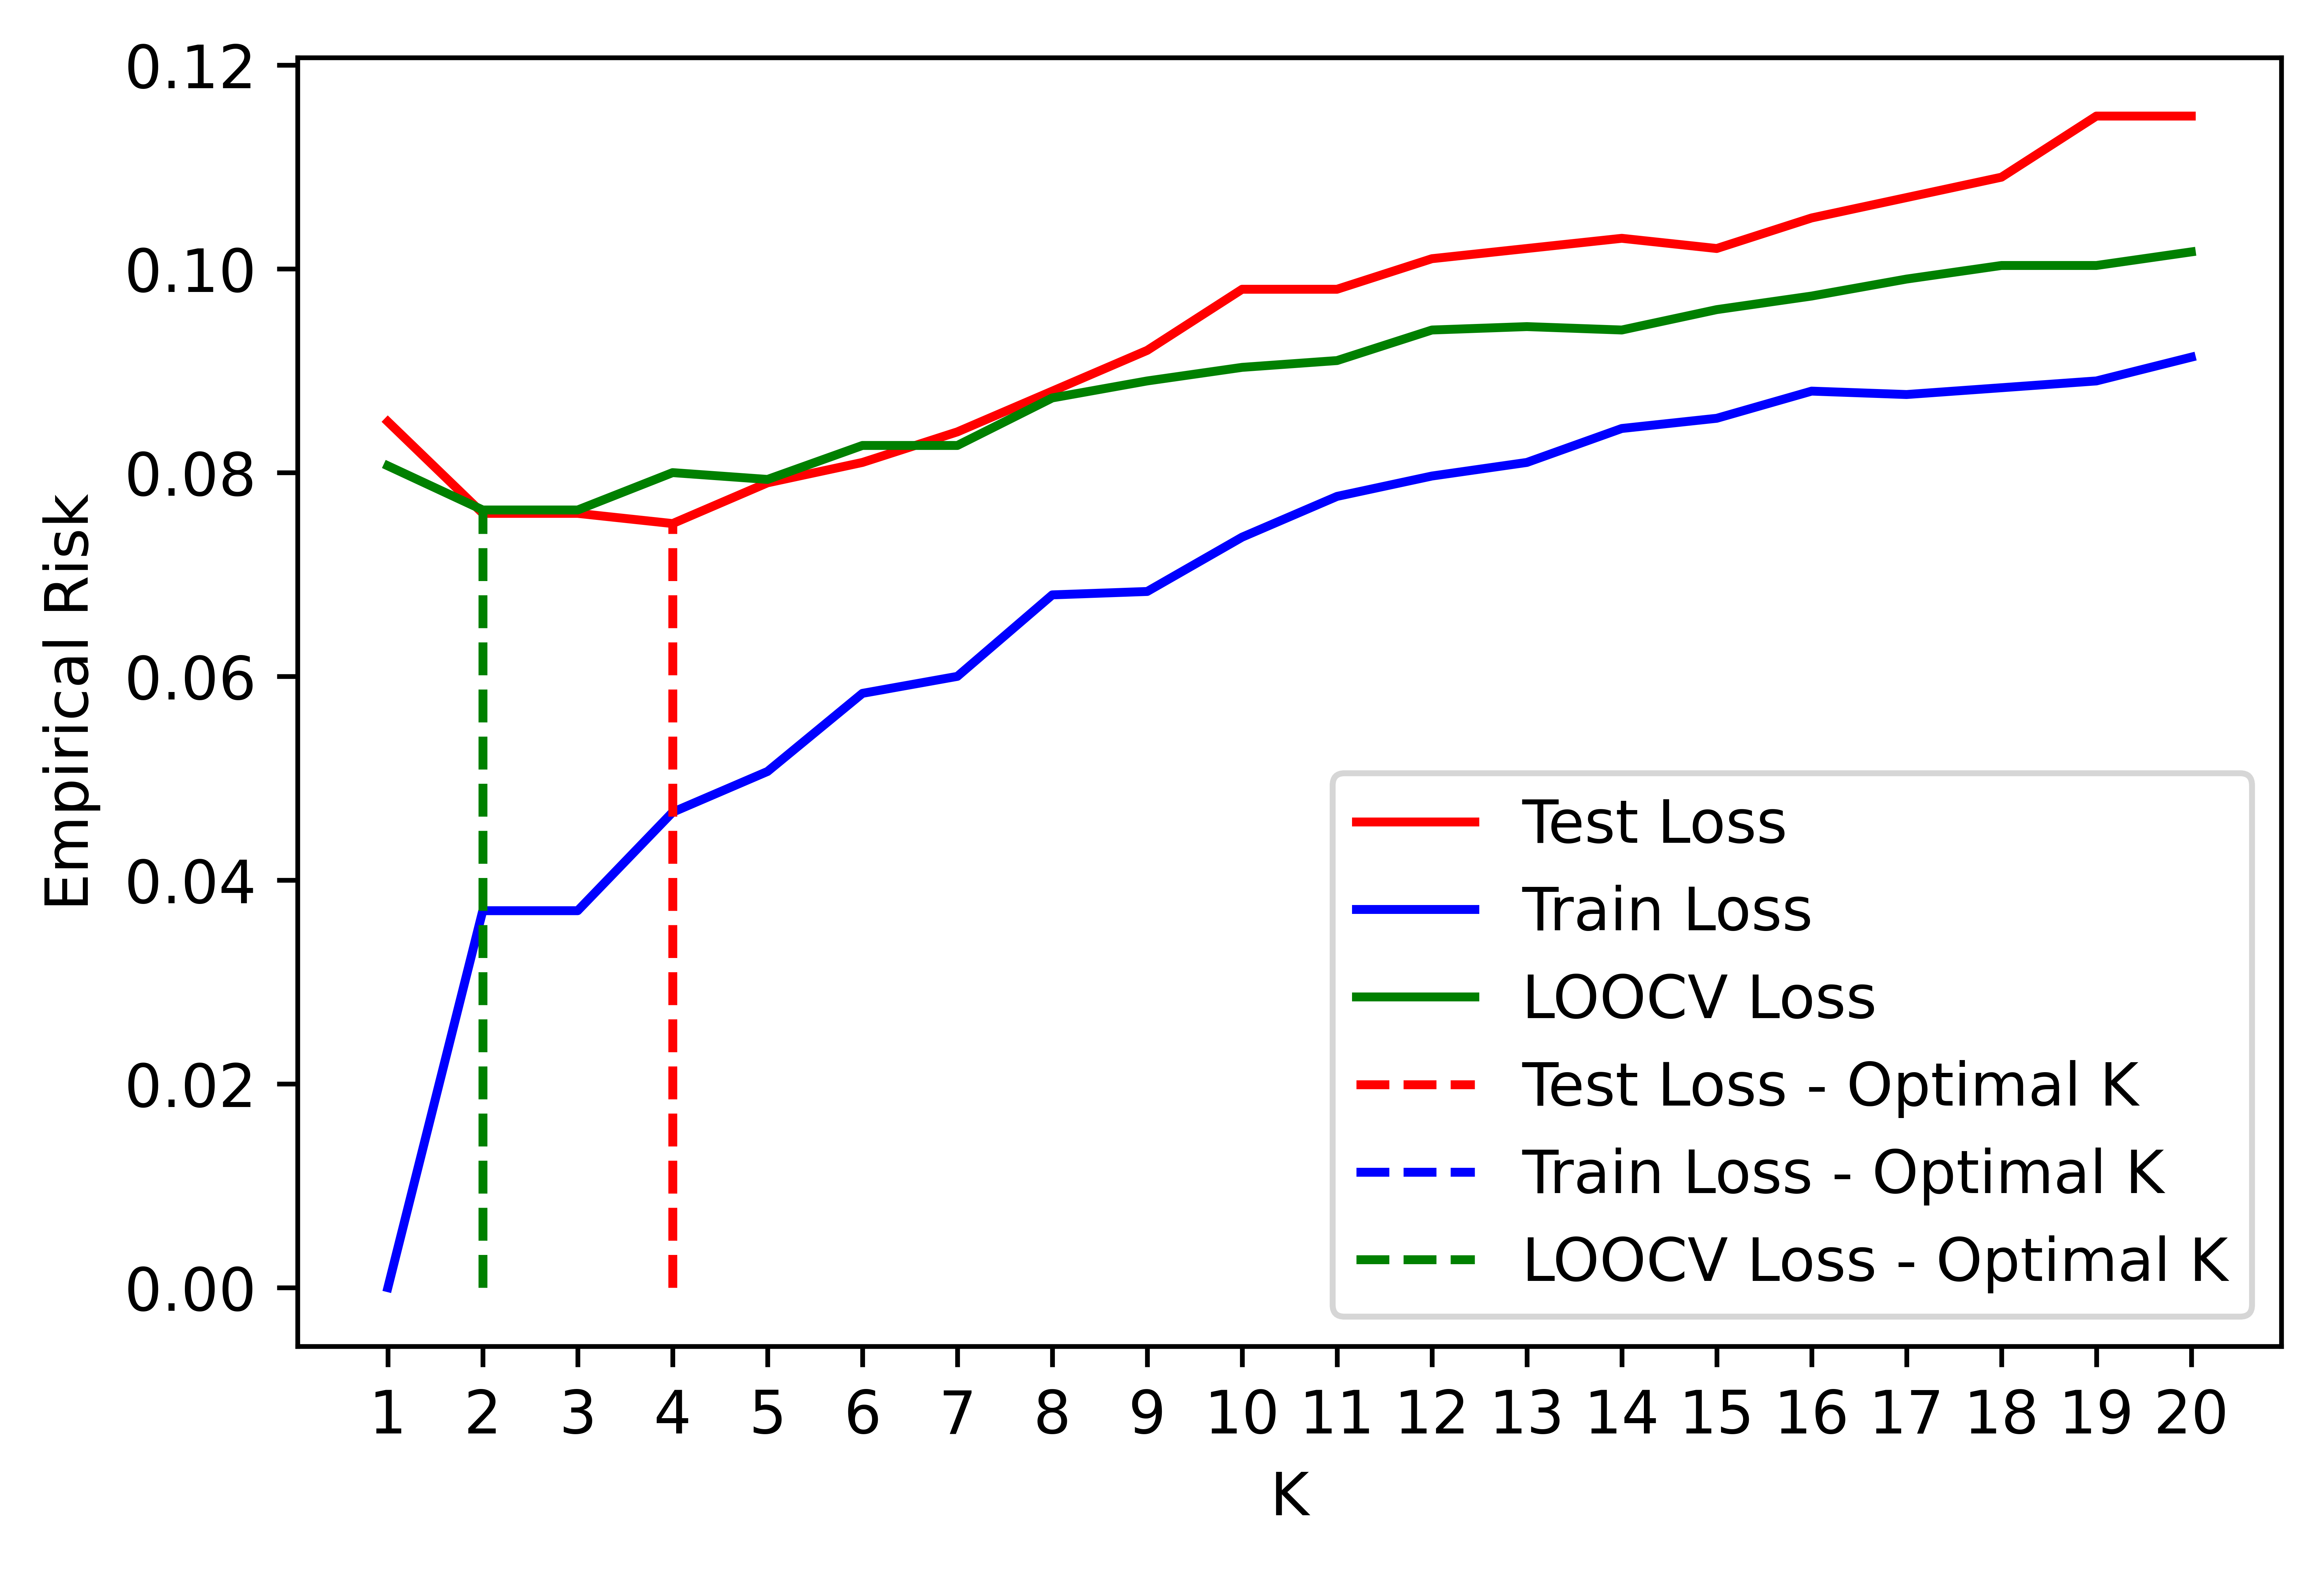

In [17]:
x_val_LOOCV = [x for x in accuracies_LOOCV]
LOOCV_risks, LOOCV_argmin_k = calc_emp_risk(accuracies_LOOCV)
y_val_LOOCV = list(LOOCV_risks.values())

plt.figure(dpi=1200)
plt.plot(x_val_test, y_val_test, label = 'Test Loss', color='r')
plt.plot(x_val_train, y_val_train, label = "Train Loss", color='b')
plt.plot(x_val_LOOCV, y_val_LOOCV, label = 'LOOCV Loss', color='g')
plt.vlines(test_argmin_k, 0, test_risks[test_argmin_k], label='Test Loss - Optimal K', linestyles='--', colors='r')
plt.vlines(train_argmin_k, 0, train_risks[train_argmin_k], label='Train Loss - Optimal K', linestyles='--', colors='b')
plt.vlines(LOOCV_argmin_k, 0, LOOCV_risks[LOOCV_argmin_k], label='LOOCV Loss - Optimal K', linestyles='--', colors='g')
#plt.title('Empirical Risk for different K')
plt.legend()
plt.ylabel("Empirical Risk")
plt.xlabel("K")
plt.xticks(x_val_test)
plt.savefig("K_comparison_LOOCV.jpeg")

Question C:

In [12]:
def minowski_distance(vec1, vec2, p = 1):
    diffvec = np.absolute(np.subtract(vec1, vec2))
    powvec = np.power(diffvec, p, dtype=object)
    distsum = np.sum(powvec, dtype=object)
    dist = np.power(distsum, (1/p), dtype=object)
    return dist

In [13]:
def get_accuracies_LOOCV_for_p(X_train, y_train, distance_function = euclidean_distance, k = [10], p = 1, updates = 250):
    X_train_num = X_train.to_numpy()
    iter = 0
    correct_counters = dict([(x, {"correct": 0, "false": 0}) for x in k])
    for index, row in X_train.iterrows():
        preds = KNNFunctions.predict_for_multiple_k(row.to_numpy(), distance_function, X_train_num, y_train, k, LOOCV = True, p = p)
        correct = y_train.iloc[index]
        for k_val, pred in preds:
            if correct == pred:
                correct_counters[k_val]["correct"] += + 1
            else:
                correct_counters[k_val]["false"] += + 1
        iter = iter + 1
        if iter % updates == 0:
            print(f'iter: {index} {correct_counters}')
    return correct_counters, p

In [14]:
def nested_dict_values(d):
    for v in d.values():
        if isinstance(v, dict):
            yield from nested_dict_values(v)
        else:
            yield v

In [15]:
multi_threading = False
load_result_from_disk = True
save_result_to_disk = False
accuracies_LOOCV_optimized_p = {}

if load_result_from_disk:
    with open('nested_cv.json', 'r') as fp:
        accuracies_LOOCV_optimized_p = json.load(fp)
else:
    if multi_threading:
        with Pool(len(range(1,16))) as pool:
            args = [(X_train, y_train, minkowski_distance, list(range(1,21)), p_prime, 1000) for p_prime in range(1,16)]
            for result in tqdm.tqdm(pool.istarmap(LossFunctions.l01_loss_LOOCV_for_p, args), total=len(args)):
                accuracies_LOOCV_optimized_p[result[1]] = result[0]
                print(result)
    else:
        for p in range(1,16):
            print('Optimizing for p =', p)
            accuracies_LOOCV_optimized_p[p] = LossFunctions.l01_loss_LOOCV_for_p(X_train, y_train, \
                                                                                    distance_function = minkowski_distance, \
                                                                                    k = list(range(1,21)), \
                                                                                    p = p, \
                                                                                    updates = 1000)[0]

    if save_result_to_disk:
        with open('nested_cv.json', 'w') as fp:
            json.dump(accuracies_LOOCV_optimized_p, fp)

# argmin k
best_k_risks = {}
for p, k in accuracies_LOOCV_optimized_p.items():
    k_risks_for_p, opt_k = calc_emp_risk(k)
    best_k_risks[p] = { opt_k : k_risks_for_p[opt_k] }
print(best_k_risks.values()) # Returns k = 2 for each p as the lowest empirical risk

# argmin p
min_k = min(list(nested_dict_values(best_k_risks)))
argmin_p = [p for p in best_k_risks if list(best_k_risks[p].values())[0] == min_k][0]
argmin_k = list(best_k_risks[p].keys())[0]

dict_values([{'2': 0.08866666666666666}, {'2': 0.07633333333333334}, {'2': 0.06899999999999999}, {'2': 0.06733333333333333}, {'2': 0.06366666666666666}, {'2': 0.062}, {'2': 0.05933333333333333}, {'2': 0.058666666666666666}, {'2': 0.058666666666666666}, {'2': 0.06}, {'2': 0.06}, {'2': 0.061}, {'2': 0.06166666666666666}, {'2': 0.06266666666666666}, {'2': 0.06333333333333332}])


Best choice for p =  8
Best choice for k =  2


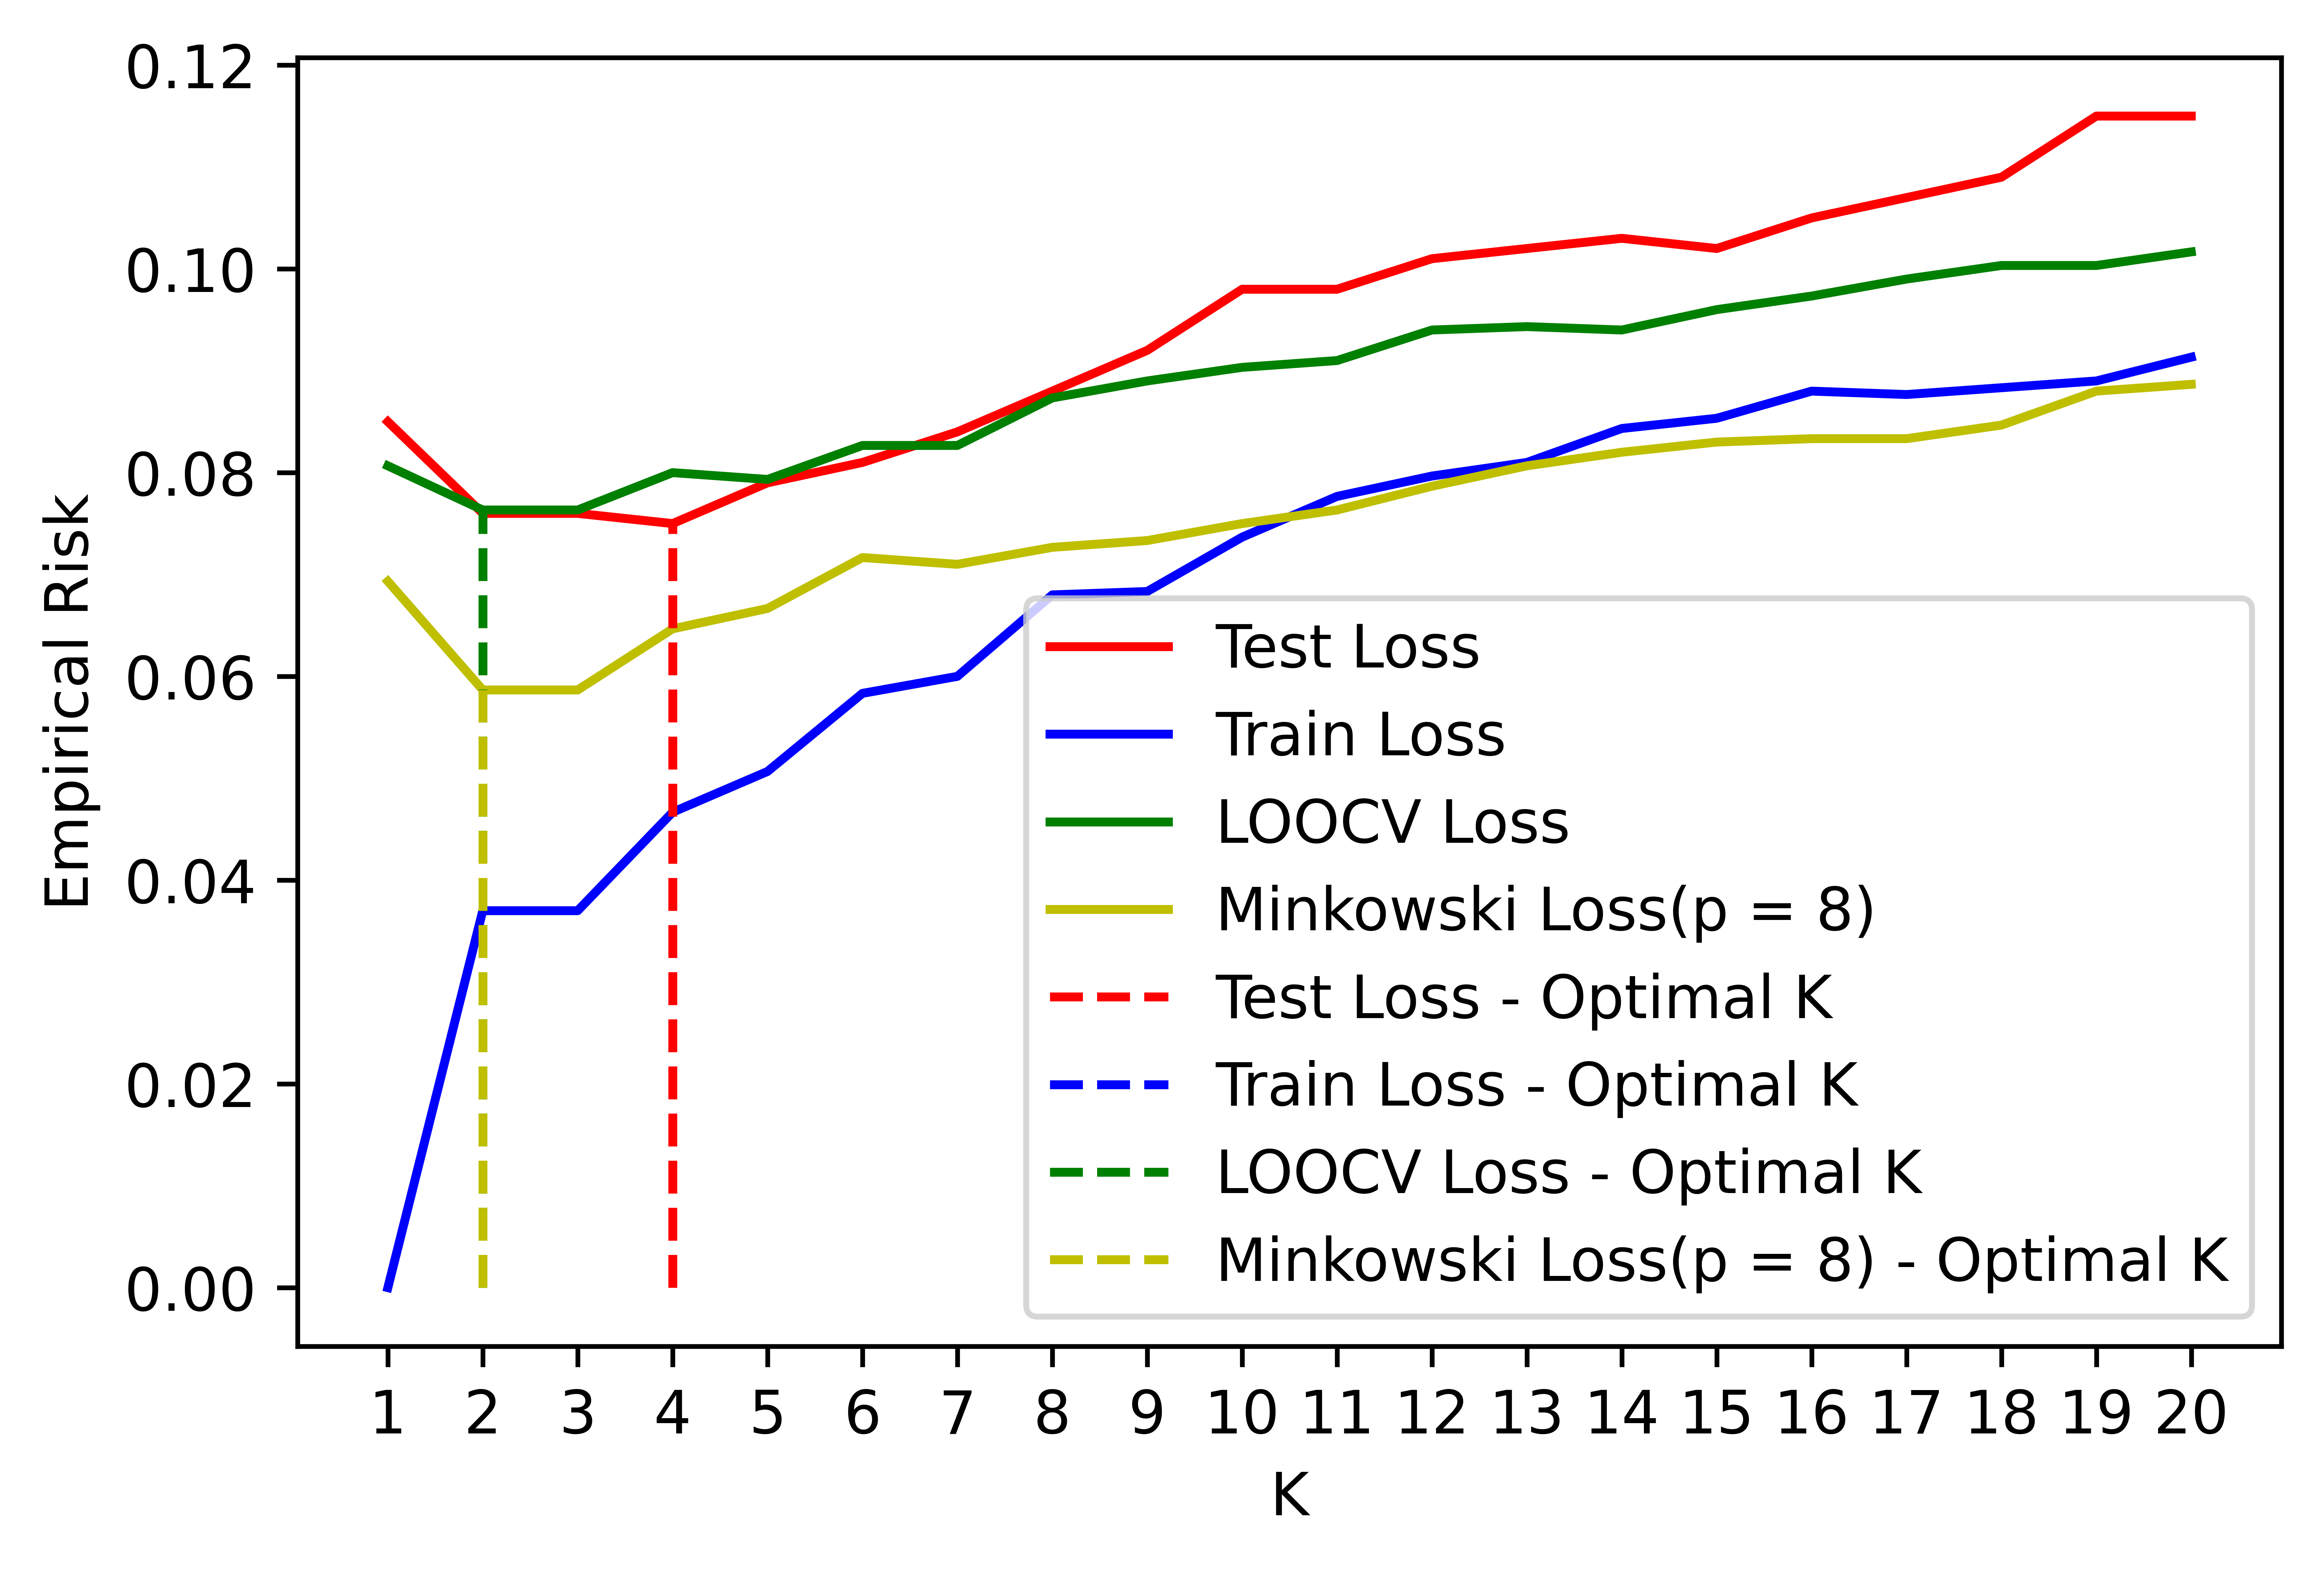

In [18]:
print('Best choice for p = ', argmin_p)
print('Best choice for k = ', argmin_k)
accuracies_LOOCV_best_p = accuracies_LOOCV_optimized_p[argmin_p]
x_val_LOOCV_best_p = [int(x) for x in accuracies_LOOCV_best_p]
LOOCV_minkowski_risks, LOOCV_minkowski_argmin_k = calc_emp_risk(accuracies_LOOCV_best_p)
y_val_LOOCV_best_p = list(LOOCV_minkowski_risks.values())

plt.figure(dpi=1200)
plt.plot(x_val_test, y_val_test, label = 'Test Loss', color='r')
plt.plot(x_val_train, y_val_train, label = "Train Loss", color='b')
plt.plot(x_val_LOOCV, y_val_LOOCV, label = 'LOOCV Loss', color='g')
plt.plot(x_val_LOOCV_best_p, y_val_LOOCV_best_p, label = f"Minkowski Loss(p = {argmin_p})", color='y')
plt.vlines(test_argmin_k, 0, test_risks[test_argmin_k], label='Test Loss - Optimal K', linestyles='--', colors='r')
plt.vlines(train_argmin_k, 0, train_risks[train_argmin_k], label='Train Loss - Optimal K', linestyles='--', colors='b')
plt.vlines(LOOCV_argmin_k, 0, LOOCV_risks[LOOCV_argmin_k], label='LOOCV Loss - Optimal K', linestyles='--', colors='g')
plt.vlines(int(LOOCV_minkowski_argmin_k), 0, LOOCV_minkowski_risks[LOOCV_minkowski_argmin_k], label=f'Minkowski Loss(p = {argmin_p}) - Optimal K', linestyles='--', colors='y')
#plt.title('Empirical Risk for different K')
plt.legend()
plt.ylabel("Empirical Risk")
plt.xlabel("K")
plt.xticks(x_val_test)
plt.savefig("K_comparison_LOOCV_minkowski_best_p.jpeg")

Question D